<a href="https://colab.research.google.com/github/OdinViolet/Neuromatch/blob/main/projects/fMRI/load_cichy_fMRI_MEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loader

## Summary

Here we will load data from Cichy et al. 2014 [1]. The data consist of fMRI responses from early visual cortex (EVC) and inferior temporal (IT) cortex and MEG responses at different timepoints in the form of representational dissimilarity matrices (RDMs) to 92 images. These images belong to different categories as shown in the Figure below.

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content/blob/main/projects/fMRI/static/cichy_fMRI_MEG_fig1.png?raw=True'/></p>

## Representational Similarity Analysis (RSA)

RSA is a method to relate signals from different source spaces (such as behavior, neural responses, DNN activations) by abstracting signals from
separate source spaces into a common similarity space. For this, in each source space, condition-specific responses are compared to each other for dissimilarity (e.g., by calculating Euclidean distances between signals), and the values are aggregated in so-called representational dissimilarity matrices (RDMs) indexed in rows and columns by the conditions compared. RDMs thus summarize the representational geometry of the source space signals. Different from source space signals themselves, RDMs from different sources spaces are directly comparable to each other for similarity and thus can relate signals from different spaces.

The figure below illustrates how RSA can be applied to different problems by comparing RDMs of different modalities/species.

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content/blob/main/projects/fMRI/static/cichy_fMRI_MEG_fig2.png?raw=True'/></p>

## Data from Cichy et al., 2014

In the cells below, we will download and visualize MEG and fMRI RDMs. Please refer Figure 1 in [1] to learn details about the image category order in RDMs.

In [1]:
# Imports
import os
import cv2
import glob
import h5py
import time
import random
import urllib
import pickle
import argparse

import numpy as np
import nibabel as nib
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable as V
from torchvision import transforms as trn

In [2]:
# @title Load mat files
def loadmat(matfile):
  """Function to load .mat files.
  Parameters
  ----------
  matfile : str
      path to `matfile` containing fMRI data for a given trial.
  Returns
  -------
  dict
      dictionary containing data in key 'vol' for a given trial.
  """
  try:
    f = h5py.File(matfile)
  except (IOError, OSError):
    return sio.loadmat(matfile)
  else:
    return {name: np.transpose(f.get(name)) for name in f.keys()}

In [3]:
# @title Data download and unzip in `data/`

import os, zipfile, requests

fname = '/content/data.zip'

if os.path.isfile(fname):
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall('data/')
    print("已解压上传的 data.zip 到 data/ 文件夹！")
else:
    print("未找到 data.zip，请先手动上传该文件到当前目录！")



'''
url = "https://osf.io/7vpyh/download"
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print("Downloading data...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall('data/')
      print("Download completed!")
'''

已解压上传的 data.zip 到 data/ 文件夹！


'\nurl = "https://osf.io/7vpyh/download"\nif not os.path.isfile(fname):\n  try:\n    r = requests.get(url)\n  except requests.ConnectionError:\n    print("!!! Failed to download data !!!")\n  else:\n    if r.status_code != requests.codes.ok:\n      print("!!! Failed to download data !!!")\n    else:\n      print("Downloading data...")\n      with open(fname, "wb") as fid:\n        fid.write(r.content)\n      with zipfile.ZipFile(fname, \'r\') as zip_ref:\n        zip_ref.extractall(\'data/\')\n      print("Download completed!")\n'

## Loading MEG RDMs

In [4]:
# Load MEG RDMs for each time point for all subjects all sessions
MEG_RDMs = loadmat("data/MEG_decoding_RDMs.mat")['MEG_decoding_RDMs']
print(MEG_RDMs.shape)  # 代表数据维度：16 个被试、2 个实验会话、1301 个时间点、92 个刺激（方阵，所以两个92）

(16, 2, 1301, 92, 92)


Shape of RDM is `num_subjects x num_sessions x num_timepoints x num_stimulus x num_stimulus`

In [5]:
# average RDM across subjects and sessions
MEG_RDM_sub_averaged = np.mean(MEG_RDMs, axis=(0, 1))
# del MEG_RDMs
# print(MEG_RDM_sub_averaged)

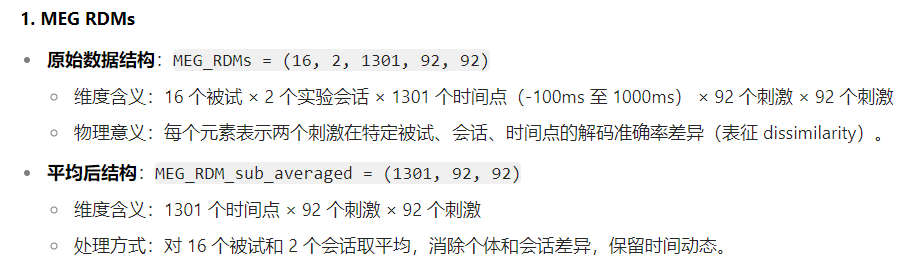

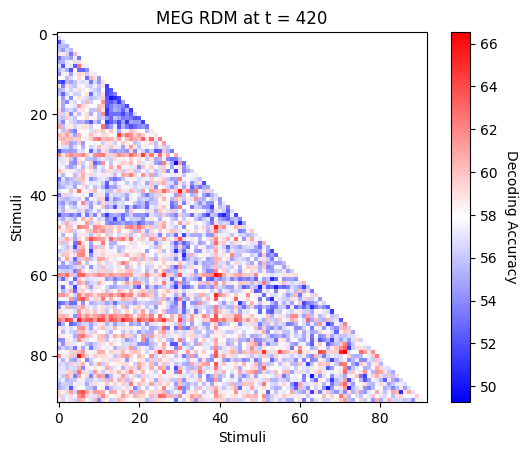

In [6]:
# @title visualize subject averaged MEG RDMs
timepoint = 420  # @param {type:"slider", min:-100, max:600, step:20}

# Load RDM at a given timepoint
# +100 as the RDMs provided are from -100ms to 1000ms after the stimulus onset
RDM = np.array(MEG_RDM_sub_averaged[timepoint+100])

# Since the matrix is symmetric we set upper triangular values to NaN
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

# plot the RDM at given timepoint
plt.imshow(RDM, cmap="bwr")
plt.title("MEG RDM at t = " + str(timepoint))
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decoding Accuracy', rotation=270)
plt.show()

##Loading fMRI RDMs

In [7]:
fMRI_file = 'data/92_Image_Set/target_fmri.mat'  # path of fMRI RDM file
fMRI_RDMs = loadmat(fMRI_file)  # load the fMRI RDMs
print(fMRI_RDMs.keys())
print(fMRI_RDMs['EVC_RDMs'].shape)

dict_keys(['EVC_RDMs', 'IT_RDMs'])
(15, 92, 92)


fMRI_RDMs is a dictionary with keys `'EVC_RDMs'` and `'IT_RDMs'` corresponding to ROIs EVC and IT respectively. The shape of each RDM is `num_subjects` $\times$ `num_stimulus` $\times$ `num_stimulus`.

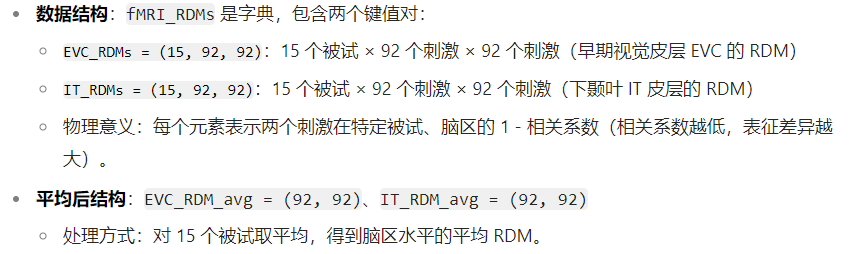

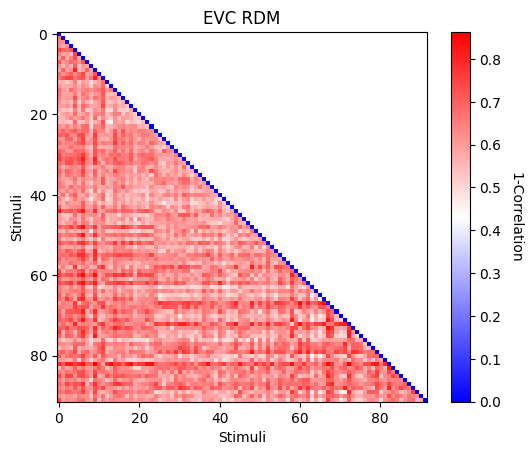

In [8]:
# @title visualize subject averaged fMRI RDMs
ROI = 'EVC'  # @param ["EVC", "IT"]

# Average the ROI RDM across subjects
RDM = np.array(fMRI_RDMs[ROI + '_RDMs'].mean(axis=0))

# Since the matrix is symmetric we set upper triangular values to NaN
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

# plot the ROI RDM at given timepoint
plt.imshow(RDM, cmap="bwr")
plt.title(ROI + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)
plt.show()

# Example Analyses

Below we will perform two analyses:

1. MEG-fMRI comparison: To find out at which timepoint MEG representation is similar to a given ROI's representation.
2. MEG-Deep Neural Network (DNN) comparison: To find out at which timepoint MEG representation is similar to a given DNN layer's representation.

In other words, the comparison will inform us about the sequential order of visual feature processing in the cortex.

In [9]:
# @title RDM Comparison functions
from scipy.stats import spearmanr

def RSA_spearman(rdm1,rdm2):
  """
  computes and returns the spearman correlation between lower triangular
  part of the input rdms. We only need to compare either lower or upper
  triangular part of the matrix as RDM is symmetric
  """
  # get lower triangular part of the RDM1
  lt_rdm1 = get_lowertriangular(rdm1)
  # get lower triangular part of the RDM1
  lt_rdm2 = get_lowertriangular(rdm2)
  # return Spearman's correlation between lower triangular part of rdm1 & rdm2
  return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
  """
  returns lower triangular part of the matrix
  """
  num_conditions = rdm.shape[0]
  return rdm[np.tril_indices(num_conditions, -1)]

##MEG-fMRI Comparison

In [10]:
# @title Correlating MEG RDMs with fMRI RDMs
num_timepoints = MEG_RDM_sub_averaged.shape[0] #get number of timepoints

# initialize a dictionary to store MEG and ROI RDM correlation at each timepoint
MEG_correlation = {}
ROIs = ['EVC','IT']
for ROI in ROIs:
  MEG_correlation[ROI] = []

# for loop that goes over MEG RDMs at all time points and correlate with ROI RDMs
for t in range(num_timepoints):
  MEG_RDM_t = MEG_RDM_sub_averaged[t, :, :]
  for ROI in ROIs:
    ROI_RDM = np.mean(fMRI_RDMs[ROI + '_RDMs'], axis=0)
    MEG_correlation[ROI].append(RSA_spearman(ROI_RDM, MEG_RDM_t))

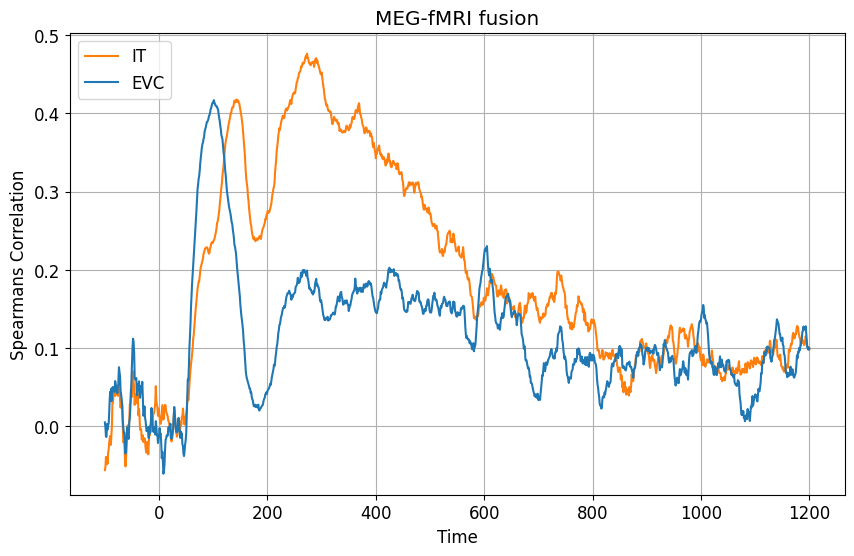

In [11]:
# @title Plotting MEG-fMRI comparison

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

time_range = range(-100, 1201)
ax.plot(time_range, MEG_correlation['IT'], color='tab:orange', label='IT')
ax.plot(time_range, MEG_correlation['EVC'], color='tab:blue', label='EVC')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Spearmans Correlation')
ax.set_title('MEG-fMRI fusion')
ax.grid(True)
ax.legend(loc='upper left')
fig.show()

## MEG-DNN Comparison

### Creating DNN (AlexNet) RDMs

In [12]:
# @title AlexNet Definition
__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# Here we redefine AlexNet differently from torchvision code for better understanding
class AlexNet(nn.Module):
  def __init__(self, num_classes=1000):
    super(AlexNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.conv3 = nn.Sequential(
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        )
    self.conv4 = nn.Sequential(
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        )
    self.conv5 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.fc6 = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        )
    self.fc7 =nn.Sequential(
        nn.Dropout(),
        nn.Linear(4096, 4096),
        )
    self.fc8 = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
        )

  def forward(self, x):
    out1 = self.conv1(x)
    out2 = self.conv2(out1)
    out3 = self.conv3(out2)
    out4 = self.conv4(out3)
    out5 = self.conv5(out4)

    out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
    out6= self.fc6(out5_reshaped)
    out7= self.fc7(out6)
    out8 = self.fc8(out7)
    return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
  """AlexNet model architecture from the
  `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
  """
  model = AlexNet(**kwargs)
  if pretrained:
    model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
  return model

In [13]:
# @title Feature extraction code

def load_alexnet(model_checkpoints):
  """This function initializes an Alexnet and load
  its weights from a pretrained model. Since we redefined model in a different
  way we have to rename the weights that were in the pretrained checkpoint.
  ----------
  model_checkpoints : str
      model checkpoints location.
  Returns
  -------
  model
      pytorch model of alexnet
  """

  model = alexnet()
  # Load checkpoint
  model_file = model_checkpoints
  checkpoint = torch.load(model_file, weights_only=False, map_location=lambda storage, loc: storage)

  # Rename the checkpoint keys according to new definition
  model_dict = ["conv1.0.weight", "conv1.0.bias",
                "conv2.0.weight", "conv2.0.bias",
                "conv3.0.weight", "conv3.0.bias",
                "conv4.0.weight", "conv4.0.bias",
                "conv5.0.weight", "conv5.0.bias",
                "fc6.1.weight", "fc6.1.bias",
                "fc7.1.weight", "fc7.1.bias",
                "fc8.1.weight", "fc8.1.bias"]
  state_dict = {}
  i = 0
  for k, v in checkpoint.items():
    state_dict[model_dict[i]] =  v
    i += 1

  # initialize model with pretrained weights
  model.load_state_dict(state_dict)
  if torch.cuda.is_available():
    model.cuda()
  model.eval()
  return model


def get_activations_and_save(model, image_list, activations_dir):
  """This function generates Alexnet features and save them in a specified directory.
  Parameters
  ----------
  model :
      pytorch model : alexnet.
  image_list : list
      the list contains path to all images.
  activations_dir : str
      save path for extracted features.
  """

  resize_normalize = trn.Compose([
                                  trn.Resize((224, 224)),
                                  trn.ToTensor(),
                                  trn.Normalize([0.485, 0.456, 0.406],
                                                [0.229, 0.224, 0.225])
                                  ])
  # for all images in the list generate and save activations
  for image_file in tqdm(image_list):
    # open image
    img = Image.open(image_file)
    image_file_name = os.path.split(image_file)[-1].split(".")[0]
    # apply transformations before feeding to model
    input_img = V(resize_normalize(img).unsqueeze(0))
    if torch.cuda.is_available():
      input_img=input_img.cuda()
    x = model.forward(input_img)

    activations = []
    for i,feat in enumerate(x):
      activations.append(feat.data.cpu().numpy().ravel())
    for layer in range(len(activations)):
      save_path = os.path.join(activations_dir,
                                f"{image_file_name}_{layer}_{layer + 1}.npy")
      np.save(save_path, activations[layer])

In [14]:
# get the paths to all the images in the stimulus set
image_dir = 'data/92_Image_Set/92images'
image_list = glob.glob(image_dir + '/*.jpg')
image_list.sort()
print(f'Total Number of Images: {len(image_list)}')
save_dir = "activations_alexnet"

######### load Alexnet initialized with pretrained weights ###################
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "alexnet.pth"
if not os.path.exists(checkpoint_path):
  url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
  urllib.request.urlretrieve(url, "alexnet.pth")
model = load_alexnet(checkpoint_path)
##############################################################################

######### get and save activations ################################

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
  os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, activations_dir)
###################################################################

Total Number of Images: 92
-------------Saving activations ----------------------------


100%|██████████| 92/92 [00:06<00:00, 14.01it/s]


In [15]:
num_layers = [1, 2, 3, 4, 5, 6, 7, 8]  # number of layers in the model
layers = []


for i in num_layers:
  layers.append(f"layer_{i}")
print(layers)


model_RDMs = {}
# create RDM for each layer from activations
for j, layer in enumerate(layers):
  j = j+1
  print(f'Working on the layer {layer}')
  print(f'Work with {j}')
  activation_files = glob.glob(activations_dir + '/*' + f'{j}.npy')
  #print(activation_files)
  activation_files.sort()
  print(f'Number of activations {len(activation_files)}')
  activations = []
  # Load all activations
  for activation_file in activation_files:
    #print(f'Working on the activation {activation_file}')
    activations.append(np.load(activation_file))
  activations = np.array(activations)
  # calculate Pearson's distance for all pairwise comparisons
  model_RDMs[layer] = 1 - np.corrcoef(activations)

['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8']
Working on the layer layer_1
Work with 1
Number of activations 92
Working on the layer layer_2
Work with 2
Number of activations 92
Working on the layer layer_3
Work with 3
Number of activations 92
Working on the layer layer_4
Work with 4
Number of activations 92
Working on the layer layer_5
Work with 5
Number of activations 92
Working on the layer layer_6
Work with 6
Number of activations 92
Working on the layer layer_7
Work with 7
Number of activations 92
Working on the layer layer_8
Work with 8
Number of activations 92


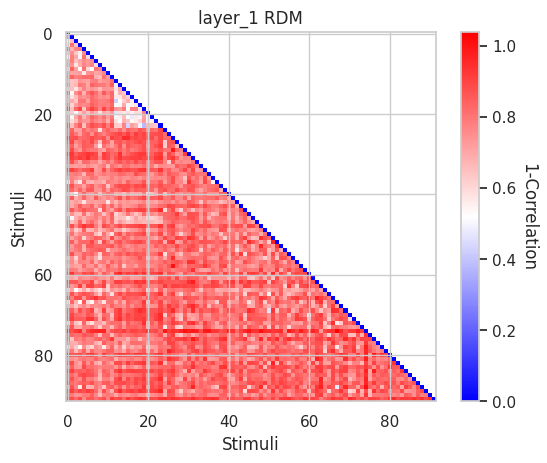

In [22]:
# @title visualize model RDMs
layer = 'layer_1'  # @param ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']

# loading layer RDM
RDM = np.array(model_RDMs[layer])

# Since the matrix is symmetric we set upper triangular values to NaN
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

# Visualize layer RDM
plt.imshow(RDM, cmap="bwr")
plt.title(layer + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)
plt.show()

### Comparing MEG RDMs with AlexNet RDMs

In [17]:
# @title Correlating MEG RDMs with DNN RDMs
# run = False
run = True

if run:
  num_timepoints = MEG_RDM_sub_averaged.shape[0]  # get number of timepoints

  # initialize a dictionary to store MEG and DNN RDM correlation at each timepoint
  for layer in layers:
    MEG_correlation[layer] = []

  # for loop that goes over MEG RDMs at all time points and correlate with DNN RDMs
  for t in range(num_timepoints):
    MEG_RDM_t = MEG_RDM_sub_averaged[t, :, :]
    for layer in layers:
      model_RDM = model_RDMs[layer]
      MEG_correlation[layer].append(RSA_spearman(model_RDM, MEG_RDM_t))

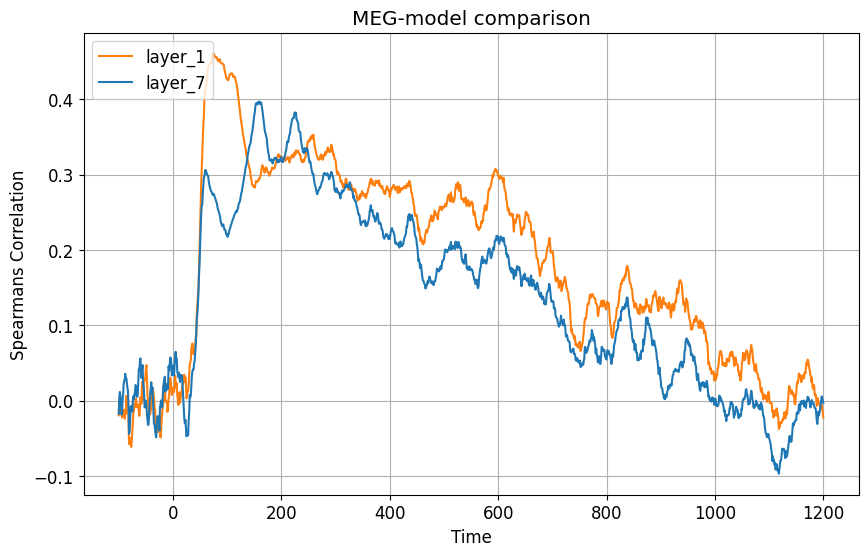

In [18]:
# @title Plotting MEG-DNN comparison
if run:

  plt.rc('font', size=12)
  fig, ax = plt.subplots(figsize=(10, 6))

  time_range = range(-100,1201)
  ax.plot(time_range, MEG_correlation['layer_1'],
          color='tab:orange', label='layer_1')
  ax.plot(time_range, MEG_correlation['layer_7'],
          color='tab:blue', label='layer_7')

  # Same as above
  ax.set_xlabel('Time')
  ax.set_ylabel('Spearmans Correlation')
  ax.set_title('MEG-model comparison')
  ax.grid(True)
  ax.legend(loc='upper left')
  fig.show()

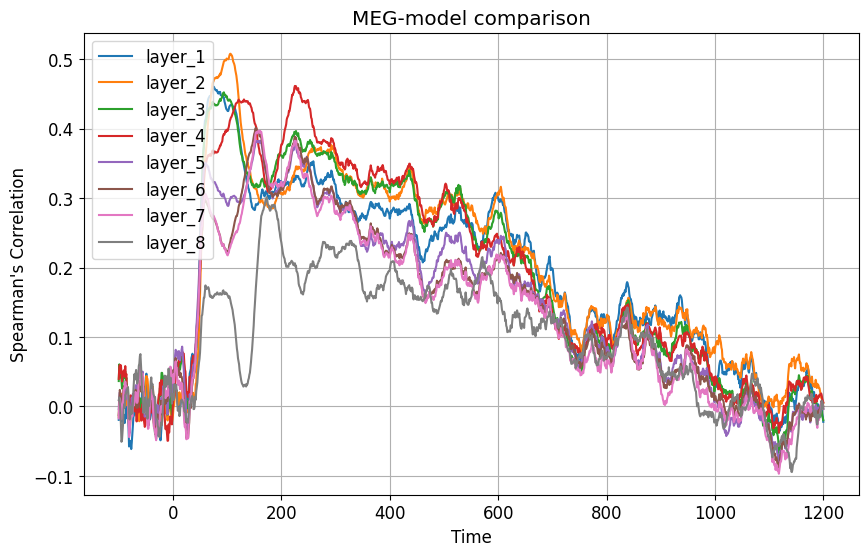

In [19]:
layers = ['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8']

if run:
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(10, 6))
    time_range = range(-100, 1201)

    # 动态遍历所有层
    for layer in layers:
        # 根据层名选择颜色（示例：用不同颜色区分层）
        color = plt.cm.tab10(layers.index(layer) % 10)
        ax.plot(time_range, MEG_correlation[layer],
                color=color, label=layer)

    ax.set_xlabel('Time')
    ax.set_ylabel("Spearman's Correlation")
    ax.set_title('MEG-model comparison')
    ax.grid(True)
    ax.legend(loc='upper left')
    fig.show()

In [20]:
def rsa_spearman(rdm1, rdm2):
    # Extract upper triangle (excluding diagonal) and flatten
    triu_idx = np.triu_indices(rdm1.shape[0], k=1)
    vec1 = rdm1[triu_idx]
    vec2 = rdm2[triu_idx]
    corr, _ = spearmanr(vec1, vec2)
    return corr

import pandas as pd

roi_names = ['EVC', 'IT']

results = []

# MEG correlations (same as before)
num_timepoints = MEG_RDM_sub_averaged.shape[0]
for layer in model_RDMs.keys():
    model_rdm = model_RDMs[layer]
    for t in range(num_timepoints):
        meg_rdm_t = MEG_RDM_sub_averaged[t]
        corr = rsa_spearman(model_rdm, meg_rdm_t)
        results.append({
            'DataType': 'MEG',
            'Layer': layer,
            'Time': t,
            'ROI': 'NA',
            'Correlation': corr
        })

# fMRI correlations (using your dict)
for layer in model_RDMs.keys():
    model_rdm = model_RDMs[layer]
    for roi_name in roi_names:
        fmri_rdm = np.array(fMRI_RDMs[roi_name + '_RDMs'].mean(axis=0))  # average subjects
        corr = rsa_spearman(model_rdm, fmri_rdm)
        results.append({
            'DataType': 'fMRI',
            'Layer': layer,
            'Time': np.nan,
            'ROI': roi_name,
            'Correlation': corr
        })

df = pd.DataFrame(results)

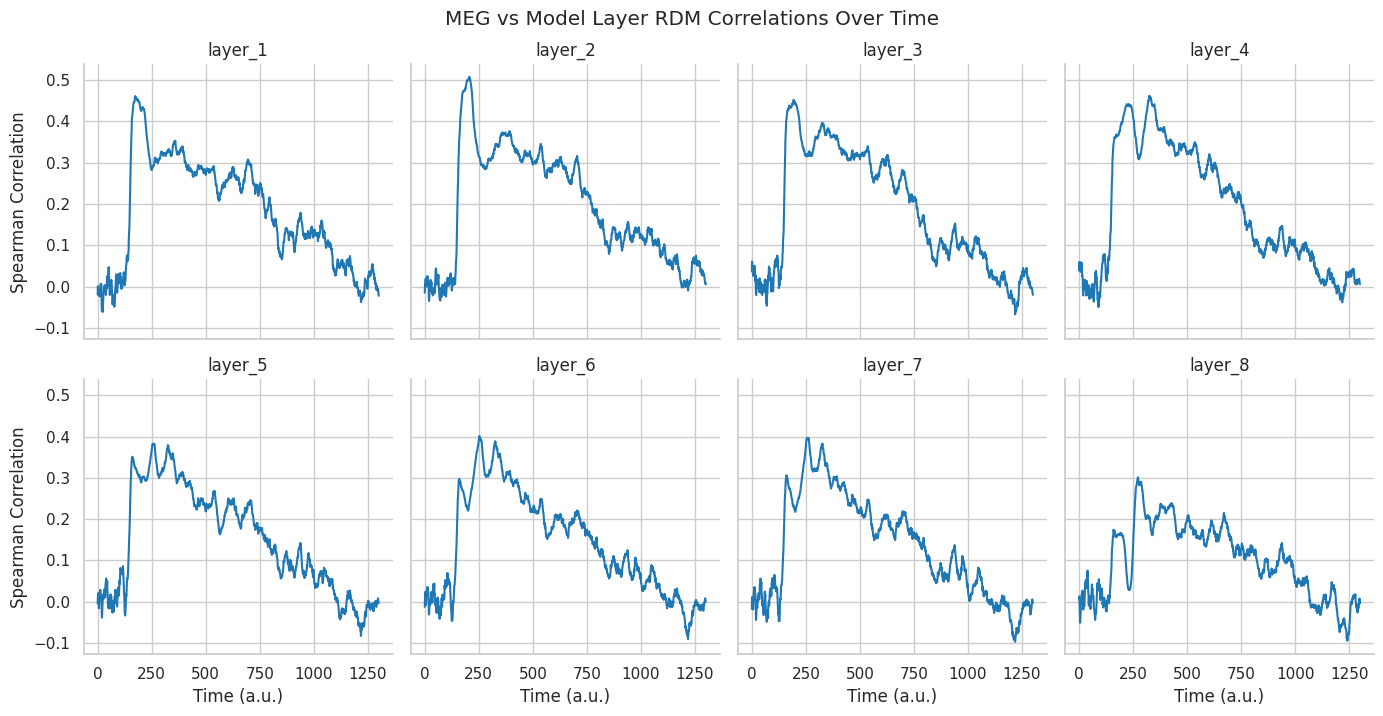

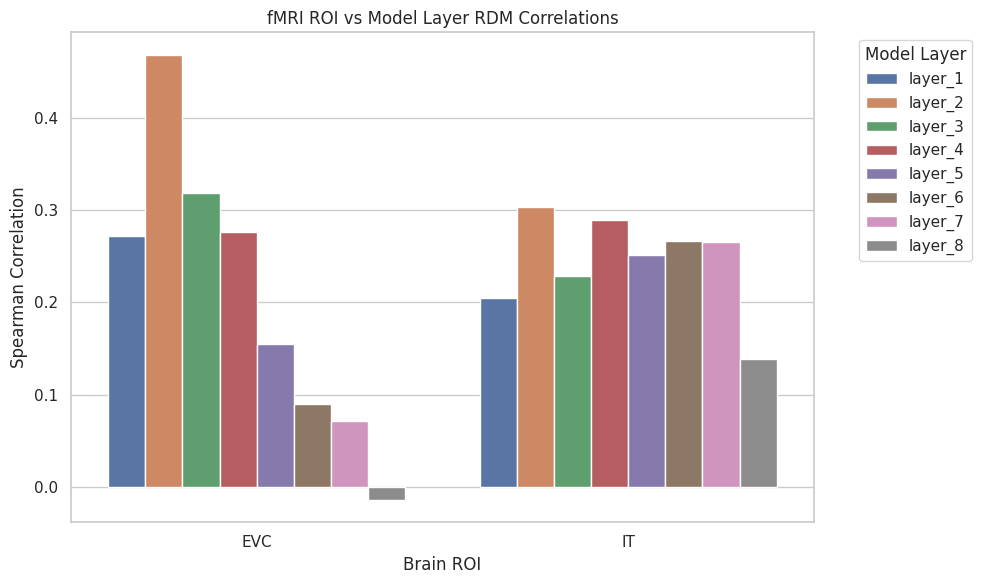

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Separate MEG and fMRI for plotting convenience
df_meg = df[df['DataType'] == 'MEG']
df_fmri = df[df['DataType'] == 'fMRI']

# Plot MEG correlations over time, faceted by layer
g = sns.FacetGrid(df_meg, col='Layer', col_wrap=4, height=3.5, sharey=True)
g.map(sns.lineplot, 'Time', 'Correlation', color='tab:blue')
g.set_axis_labels("Time (a.u.)", "Spearman Correlation")
g.set_titles("{col_name}")
g.fig.suptitle('MEG vs Model Layer RDM Correlations Over Time', y=1.02)

# Plot fMRI correlations as bar plot faceted by layer
plt.figure(figsize=(10, 6))
sns.barplot(data=df_fmri, x='ROI', y='Correlation', hue='Layer')
plt.title('fMRI ROI vs Model Layer RDM Correlations')
plt.ylabel('Spearman Correlation')
plt.xlabel('Brain ROI')
plt.legend(title='Model Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **AlexNet all codes**

In [ ]:
# @title AlexNet Definition
__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# Here we redefine AlexNet differently from torchvision code for better understanding
class AlexNet(nn.Module):
  def __init__(self, num_classes=1000):
    super(AlexNet, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.conv3 = nn.Sequential(
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        )
    self.conv4 = nn.Sequential(
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        )
    self.conv5 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
    self.fc6 = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        )
    self.fc7 =nn.Sequential(
        nn.Dropout(),
        nn.Linear(4096, 4096),
        )
    self.fc8 = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
        )

  def forward(self, x):
    out1 = self.conv1(x)
    out2 = self.conv2(out1)
    out3 = self.conv3(out2)
    out4 = self.conv4(out3)
    out5 = self.conv5(out4)

    out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
    out6= self.fc6(out5_reshaped)
    out7= self.fc7(out6)
    out8 = self.fc8(out7)
    return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
  """AlexNet model architecture from the
  `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
  """
  model = AlexNet(**kwargs)
  if pretrained:
    model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
  return model



##############
# @title Feature extraction code

def load_alexnet(model_checkpoints):
  """This function initializes an Alexnet and load
  its weights from a pretrained model. Since we redefined model in a different
  way we have to rename the weights that were in the pretrained checkpoint.
  ----------
  model_checkpoints : str
      model checkpoints location.
  Returns
  -------
  model
      pytorch model of alexnet
  """

  model = alexnet()
  # Load checkpoint
  model_file = model_checkpoints
  checkpoint = torch.load(model_file, weights_only=False, map_location=lambda storage, loc: storage)

  # Rename the checkpoint keys according to new definition
  model_dict = ["conv1.0.weight", "conv1.0.bias",
                "conv2.0.weight", "conv2.0.bias",
                "conv3.0.weight", "conv3.0.bias",
                "conv4.0.weight", "conv4.0.bias",
                "conv5.0.weight", "conv5.0.bias",
                "fc6.1.weight", "fc6.1.bias",
                "fc7.1.weight", "fc7.1.bias",
                "fc8.1.weight", "fc8.1.bias"]
  state_dict = {}
  i = 0
  for k, v in checkpoint.items():
    state_dict[model_dict[i]] =  v
    i += 1

  # initialize model with pretrained weights
  model.load_state_dict(state_dict)
  if torch.cuda.is_available():
    model.cuda()
  model.eval()
  return model


def get_activations_and_save(model, image_list, activations_dir):
  """This function generates Alexnet features and save them in a specified directory.
  Parameters
  ----------
  model :
      pytorch model : alexnet.
  image_list : list
      the list contains path to all images.
  activations_dir : str
      save path for extracted features.
  """

  resize_normalize = trn.Compose([
                                  trn.Resize((224, 224)),
                                  trn.ToTensor(),
                                  trn.Normalize([0.485, 0.456, 0.406],
                                                [0.229, 0.224, 0.225])
                                  ])
  # for all images in the list generate and save activations
  for image_file in tqdm(image_list):
    # open image
    img = Image.open(image_file)
    image_file_name = os.path.split(image_file)[-1].split(".")[0]
    # apply transformations before feeding to model
    input_img = V(resize_normalize(img).unsqueeze(0))
    if torch.cuda.is_available():
      input_img=input_img.cuda()
    x = model.forward(input_img)

    activations = []
    for i,feat in enumerate(x):
      activations.append(feat.data.cpu().numpy().ravel())
    for layer in range(len(activations)):
      save_path = os.path.join(activations_dir,
                                f"{image_file_name}_{layer}_{layer + 1}.npy")
      np.save(save_path, activations[layer])

##########
  # get the paths to all the images in the stimulus set
image_dir = 'data/92_Image_Set/92images'
image_list = glob.glob(image_dir + '/*.jpg')
image_list.sort()
print(f'Total Number of Images: {len(image_list)}')
save_dir = "activations_alexnet"

######### load Alexnet initialized with pretrained weights ###################
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "alexnet.pth"
if not os.path.exists(checkpoint_path):
  url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
  urllib.request.urlretrieve(url, "alexnet.pth")
model = load_alexnet(checkpoint_path)
##############################################################################

######### get and save activations ################################

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
  os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, activations_dir)
###################################################################



num_layers = [1, 2, 3, 4, 5, 6, 7, 8]  # number of layers in the model
layers = []


for i in num_layers:
  layers.append(f"layer_{i}")
print(layers)


model_RDMs = {}
# create RDM for each layer from activations
for j, layer in enumerate(layers):
  j = j+1
  print(f'Working on the layer {layer}')
  print(f'Work with {j}')
  activation_files = glob.glob(activations_dir + '/*' + f'{j}.npy')
  #print(activation_files)
  activation_files.sort()
  print(f'Number of activations {len(activation_files)}')
  activations = []
  # Load all activations
  for activation_file in activation_files:
    #print(f'Working on the activation {activation_file}')
    activations.append(np.load(activation_file))
  activations = np.array(activations)
  # calculate Pearson's distance for all pairwise comparisons
  model_RDMs[layer] = 1 - np.corrcoef(activations)

# References

1. Cichy et al., (2014) Resolving human object recognition in space and time. _Nature Neuroscience_ **17**: 455-462. doi: [10.1038/nn.3635](https://doi.org/10.1038/nn.3635)
2. Kriegeskorte et al., (2008). Representational similarity analysis – connecting the branches of systems neuroscience. _Frontiers in Systems Neuroscience_ **2**: 4. doi: [10.3389/neuro.06.004.2008](https://doi.org/10.3389/neuro.06.004.2008)

# **Creating other model - ResNet18(v1.0)**

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]
100%|██████████| 92/92 [00:12<00:00,  7.36it/s]


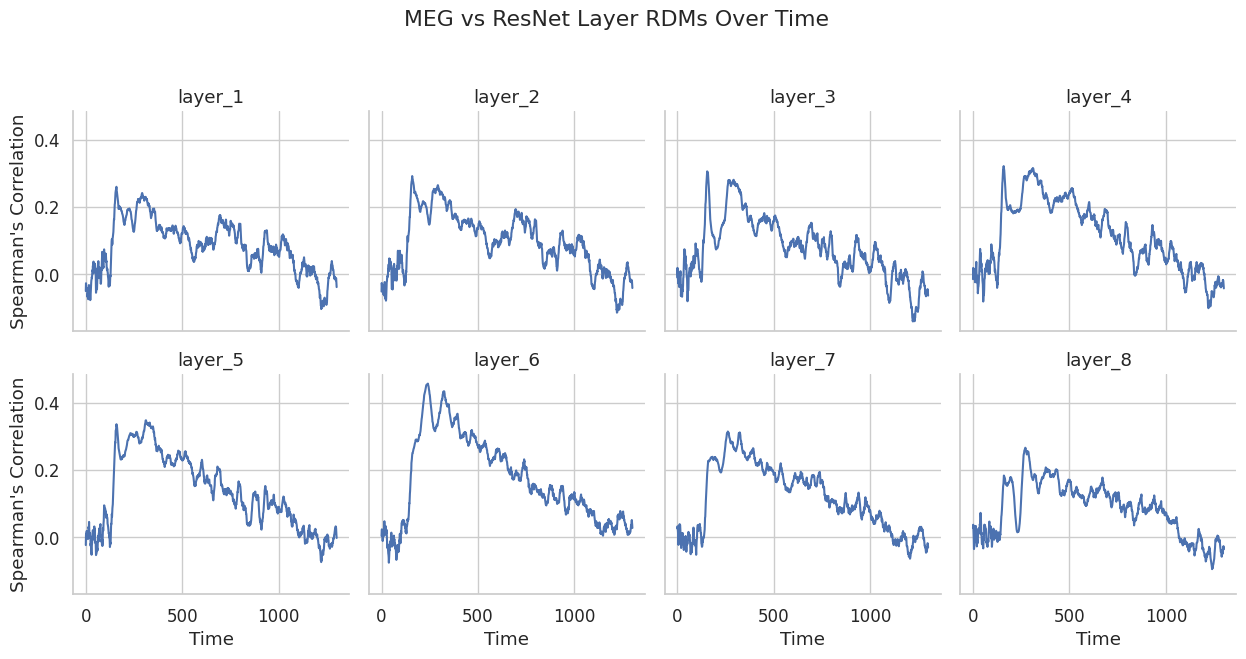

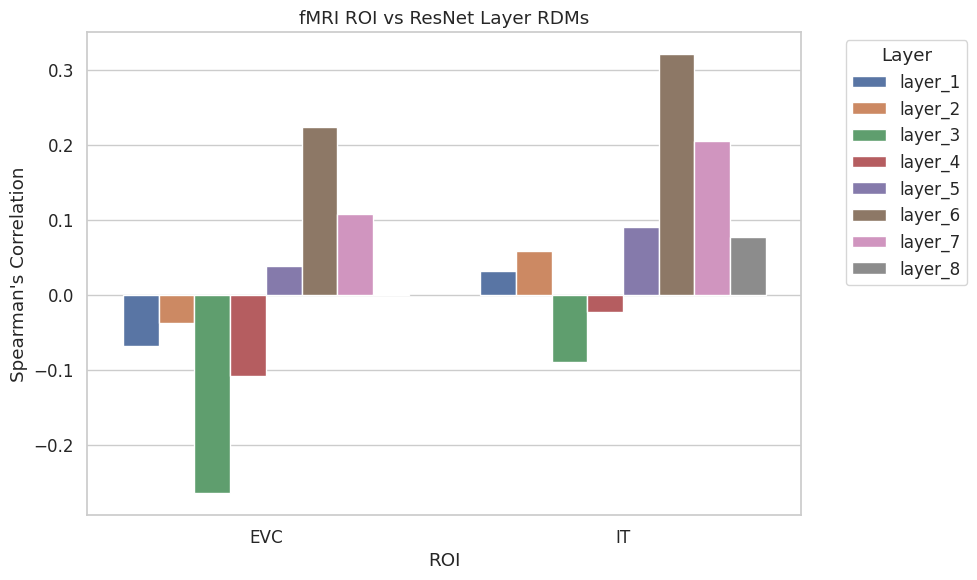

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os, glob
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 特征提取模型
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.selected_layers = selected_layers

        self.model = nn.Sequential(OrderedDict([
            ('conv1', resnet.conv1),
            ('bn1', resnet.bn1),
            ('relu', resnet.relu),
            ('maxpool', resnet.maxpool),
            ('layer1', resnet.layer1),
            ('layer2', resnet.layer2),
            ('layer3', resnet.layer3),
            ('layer4', resnet.layer4),
            ('avgpool', resnet.avgpool),
        ]))
        self.fc = resnet.fc

    def forward(self, x):
        activations = []
        for name, module in self.model.named_children():
            x = module(x)
            if name in self.selected_layers:
                activations.append(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if 'fc' in self.selected_layers:
            activations.append(x)
        return activations

# 提取特征
def extract_resnet_features(model, image_list, save_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    model.eval()
    if torch.cuda.is_available():
        model.cuda()

    for img_path in tqdm(image_list):
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
        with torch.no_grad():
            feats = model(input_tensor)
        basename = os.path.splitext(os.path.basename(img_path))[0]
        for i, feat in enumerate(feats):
            np_feat = feat.cpu().numpy().ravel()
            np.save(os.path.join(save_dir, f"{basename}_layer{i+1}.npy"), np_feat)

# 计算 RDM
def compute_model_rdms(activation_dir, num_layers):
    model_RDMs = {}
    for layer in range(1, num_layers + 1):
        files = sorted(glob.glob(os.path.join(activation_dir, f'*_layer{layer}.npy')))
        data = [np.load(f) for f in files]
        data = np.array(data)
        rdm = 1 - np.corrcoef(data)
        model_RDMs[f'layer_{layer}'] = rdm
    return model_RDMs

# RSA Spearman 计算
def rsa_spearman(rdm1, rdm2):
    triu = np.triu_indices(rdm1.shape[0], k=1)
    return spearmanr(rdm1[triu], rdm2[triu])[0]

# RSA 对比
def compute_rsa_correlations(model_RDMs, MEG_RDM, fMRI_RDMs):
    results = []
    for layer in model_RDMs:
        model_rdm = model_RDMs[layer]

        # MEG over time
        for t in range(MEG_RDM.shape[0]):
            corr = rsa_spearman(model_rdm, MEG_RDM[t])
            results.append({'DataType': 'MEG', 'Layer': layer, 'Time': t, 'ROI': 'NA', 'Correlation': corr})

        # fMRI over ROIs
        for roi in ['EVC', 'IT']:
            fmri_rdm = fMRI_RDMs[roi + '_RDMs'].mean(axis=0)
            corr = rsa_spearman(model_rdm, fmri_rdm)
            results.append({'DataType': 'fMRI', 'Layer': layer, 'Time': np.nan, 'ROI': roi, 'Correlation': corr})
    return results

# 可视化结果
def plot_rsa_results(results):
    df = pd.DataFrame(results)
    sns.set(style='whitegrid', font_scale=1.1)

    # MEG Time Course
    df_meg = df[df['DataType'] == 'MEG']
    g = sns.FacetGrid(df_meg, col='Layer', col_wrap=4, height=3.2, sharey=True)
    g.map(sns.lineplot, 'Time', 'Correlation')
    g.set_titles("{col_name}")
    g.set_axis_labels("Time", "Spearman's Correlation")
    g.fig.suptitle('MEG vs ResNet Layer RDMs Over Time', y=1.03)
    plt.tight_layout()
    plt.show()

    # fMRI Bars
    df_fmri = df[df['DataType'] == 'fMRI']
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_fmri, x='ROI', y='Correlation', hue='Layer')
    plt.title('fMRI ROI vs ResNet Layer RDMs')
    plt.xlabel('ROI')
    plt.ylabel("Spearman's Correlation")
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ==== 主程序区域 ====
# 路径设定
image_dir = 'data/92_Image_Set/92images'
save_dir = 'resnet_activations'
os.makedirs(save_dir, exist_ok=True)

# 加载图像列表
image_list = sorted(glob.glob(image_dir + '/*.jpg'))

# 初始化模型（8层）
selected_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
model = ResNetFeatureExtractor(selected_layers)

# 提取特征
extract_resnet_features(model, image_list, save_dir)

# 构建模型 RDMs
model_RDMs = compute_model_rdms(save_dir, len(selected_layers))

# 加载脑数据（需预先准备）
# MEG_RDM_sub_averaged: shape = (1301, N, N)
# fMRI_RDMs = {'EVC_RDMs': [...], 'IT_RDMs': [...]}

# 比较 RDMs
results = compute_rsa_correlations(model_RDMs, MEG_RDM_sub_averaged, fMRI_RDMs)

# 可视化
plot_rsa_results(results)


# **Creating other model - VGG16**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.5MB/s]
100%|██████████| 92/92 [01:06<00:00,  1.39it/s]


Processing layer 1
Processing layer 2
Processing layer 3
Processing layer 4
Processing layer 5
Processing layer 6
Processing layer 7
Processing layer 8


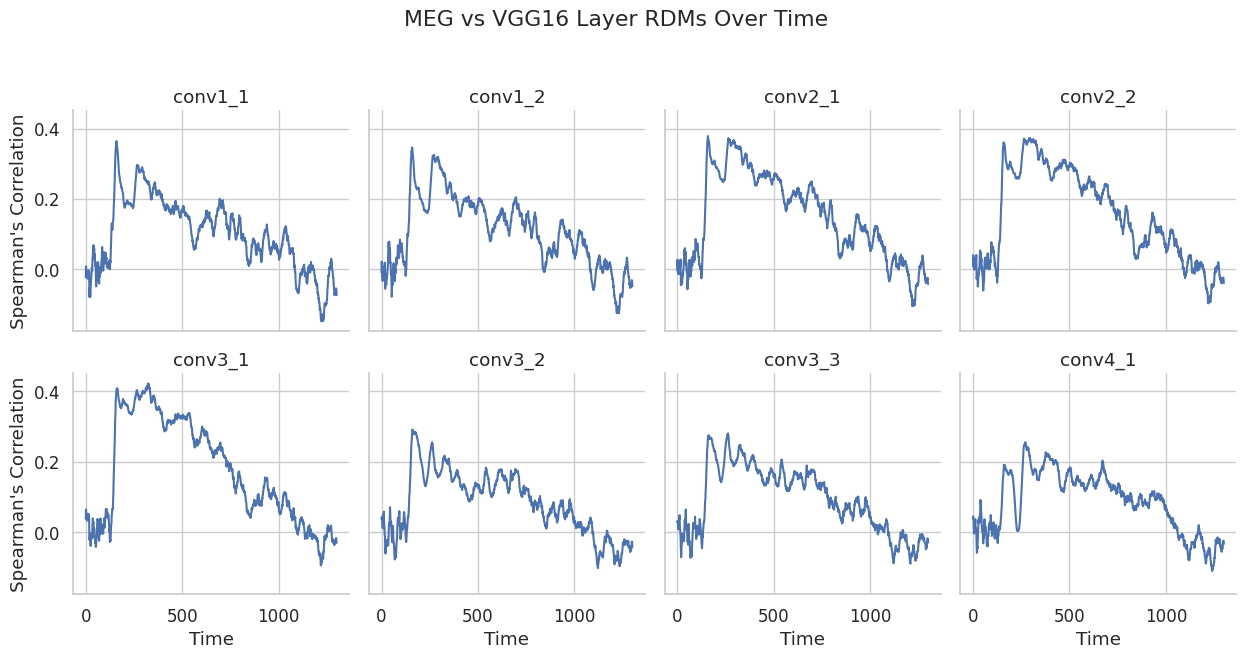

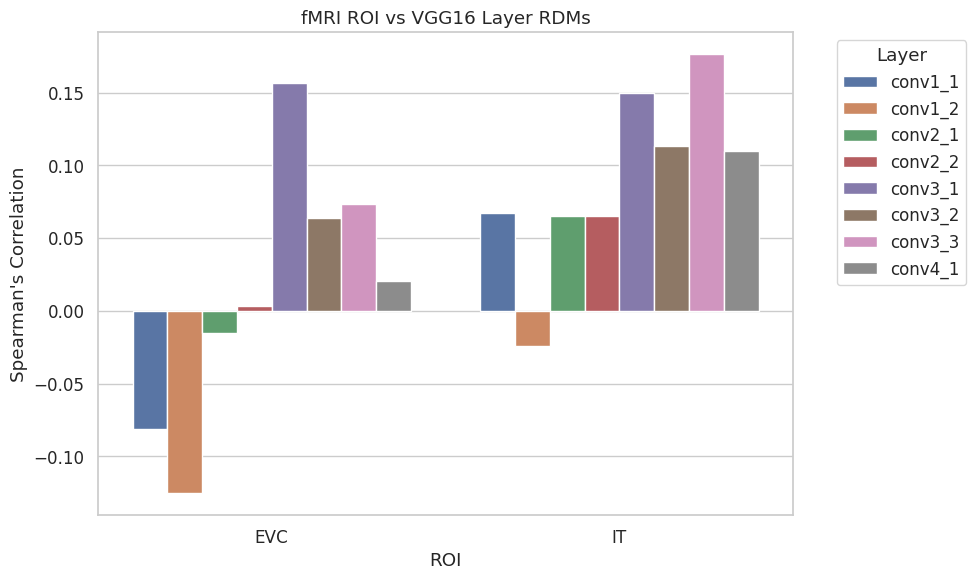

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as trn
import numpy as np
import os, glob, urllib
from tqdm import tqdm
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# VGG16 特征提取器（类似 ResNet18）
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(VGG16FeatureExtractor, self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.selected_layers = selected_layers

    def forward(self, x):
        activations = []
        # 提取特定层的特征
        for i, layer in enumerate(self.model.features):
            x = layer(x)
            if f"features.{i}" in self.selected_layers:
                activations.append(x)

        x = torch.flatten(x, 1)
        for i, layer in enumerate(self.model.classifier):
            x = layer(x)
            if f"classifier.{i}" in self.selected_layers:
                activations.append(x)

        return activations

# 提取 VGG16 特征并保存
def get_activations_and_save_vgg(model, image_list, activations_dir):
    preprocess = trn.Compose([
        trn.Resize((224, 224)),
        trn.ToTensor(),
        trn.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
    ])

    for image_file in tqdm(image_list):
        image_name = os.path.splitext(os.path.basename(image_file))[0]
        img = Image.open(image_file).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
            model.cuda()
        with torch.no_grad():
            feats = model(input_tensor)
        for i, feat in enumerate(feats):
            feat_np = feat.cpu().numpy().ravel()
            save_path = os.path.join(activations_dir, f"{image_name}_layer{i+1}.npy")
            np.save(save_path, feat_np)

# 计算 RDM
def compute_rdms(activations_dir, num_layers):
    model_RDMs = {}
    for layer in range(1, num_layers + 1):
        print(f'Processing layer {layer}')
        files = sorted(glob.glob(os.path.join(activations_dir, f'*_layer{layer}.npy')))
        features = [np.load(f) for f in files]
        features = np.array(features)
        rdm = 1 - np.corrcoef(features)
        model_RDMs[f"layer_{layer}"] = rdm
    return model_RDMs

# RSA Spearman 计算
def rsa_spearman(rdm1, rdm2):
    triu = np.triu_indices(rdm1.shape[0], k=1)
    return spearmanr(rdm1[triu], rdm2[triu])[0]

# RSA 对比计算
def compute_rsa_correlations(model_RDMs, MEG_RDM, fMRI_RDMs):
    results = []
    for layer in model_RDMs:
        model_rdm = model_RDMs[layer]

        # MEG over time
        for t in range(MEG_RDM.shape[0]):
            corr = rsa_spearman(model_rdm, MEG_RDM[t])
            results.append({'DataType': 'MEG', 'Layer': layer, 'Time': t, 'ROI': 'NA', 'Correlation': corr})

        # fMRI over ROIs
        for roi in ['EVC', 'IT']:
            fmri_rdm = fMRI_RDMs[roi + '_RDMs'].mean(axis=0)
            corr = rsa_spearman(model_rdm, fmri_rdm)
            results.append({'DataType': 'fMRI', 'Layer': layer, 'Time': np.nan, 'ROI': roi, 'Correlation': corr})
    return results

# 可视化 RSA 结果
def plot_rsa_results(results):
    df = pd.DataFrame(results)
    sns.set(style='whitegrid', font_scale=1.1)

    # VGG16 层名称映射
    layer_name_mapping = {
        'layer_1': 'conv1_1',
        'layer_2': 'conv1_2',
        'layer_3': 'conv2_1',
        'layer_4': 'conv2_2',
        'layer_5': 'conv3_1',
        'layer_6': 'conv3_2',
        'layer_7': 'conv3_3',
        'layer_8': 'conv4_1',
        'layer_9': 'conv4_2',
        'layer_10': 'conv4_3',
        'layer_11': 'conv5_1',
        'layer_12': 'conv5_2',
        'layer_13': 'conv5_3',
        'layer_14': 'fc6',
        'layer_15': 'fc7',
        'layer_16': 'fc8'
    }

    # MEG Time Course
    df_meg = df[df['DataType'] == 'MEG']
    df_meg.loc[:, 'Layer'] = df_meg['Layer'].map(layer_name_mapping)
    g = sns.FacetGrid(df_meg, col='Layer', col_wrap=4, height=3.2, sharey=True)
    g.map(sns.lineplot, 'Time', 'Correlation')
    g.set_titles("{col_name}")
    g.set_axis_labels("Time", "Spearman's Correlation")
    g.fig.suptitle('MEG vs VGG16 Layer RDMs Over Time', y=1.03)
    plt.tight_layout()
    plt.show()

    # fMRI Bars
    df_fmri = df[df['DataType'] == 'fMRI']
    df_fmri.loc[:, 'Layer'] = df_fmri['Layer'].map(layer_name_mapping)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_fmri, x='ROI', y='Correlation', hue='Layer')
    plt.title('fMRI ROI vs VGG16 Layer RDMs')
    plt.xlabel('ROI')
    plt.ylabel("Spearman's Correlation")
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ==== 主程序区域 ====
# 路径设定
image_dir = 'data/92_Image_Set/92images'
save_dir = 'activations_vgg16'
os.makedirs(save_dir, exist_ok=True)

# 加载图像列表
image_list = sorted(glob.glob(image_dir + '/*.jpg'))

# 初始化模型（VGG16）
layer_names = ['features.0', 'features.5', 'features.10', 'features.15', 'features.20',
               'classifier.0', 'classifier.3', 'classifier.6']
model = VGG16FeatureExtractor(layer_names)
model.eval()

# 提取特征
get_activations_and_save_vgg(model, image_list, save_dir)

# 计算模型的 RDMs
model_RDMs = compute_rdms(save_dir, num_layers=len(layer_names))

# 加载脑数据（需要预先准备）
# MEG_RDM_sub_averaged: shape = (1301, N, N)
# fMRI_RDMs = {'EVC_RDMs': [...], 'IT_RDMs': [...]}

# 计算 RDMs 的 RSA 对比
results = compute_rsa_correlations(model_RDMs, MEG_RDM_sub_averaged, fMRI_RDMs)

# 绘制结果
plot_rsa_results(results)


# **Creating other model - ResNet18(v2.0)**

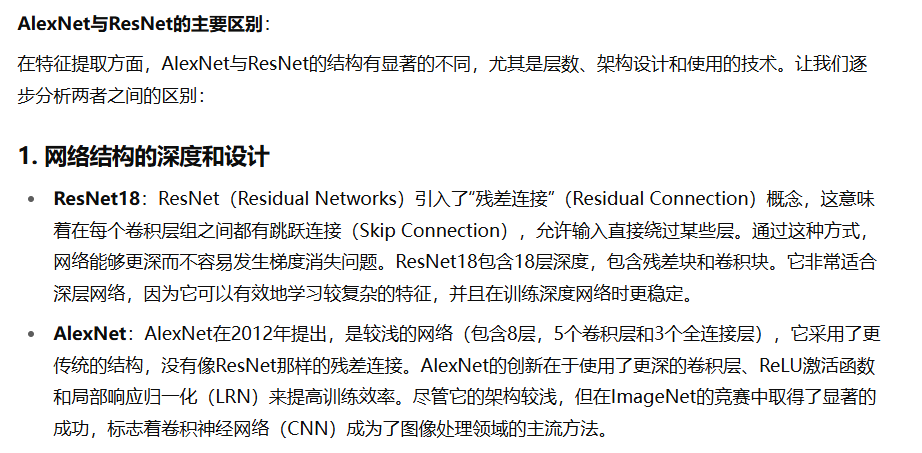

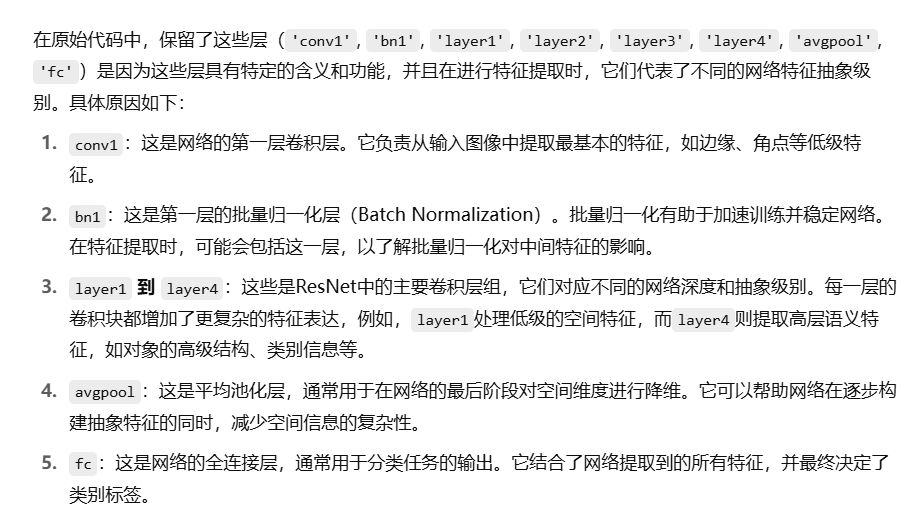

100%|██████████| 92/92 [00:12<00:00,  7.52it/s]


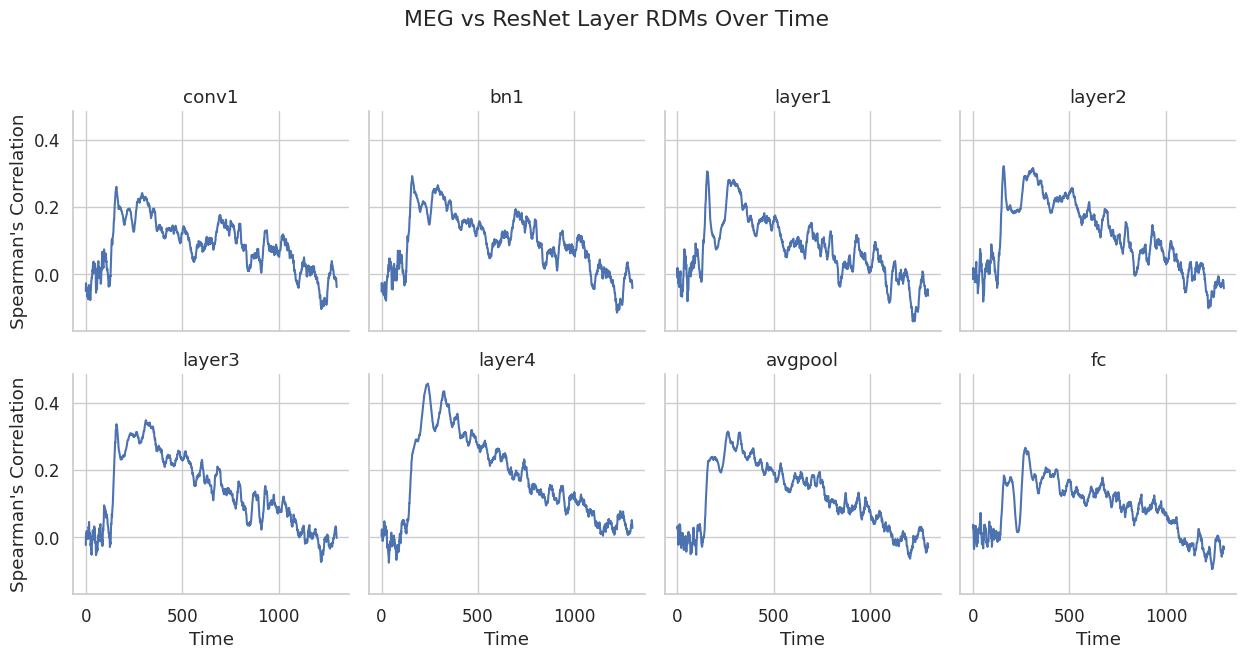

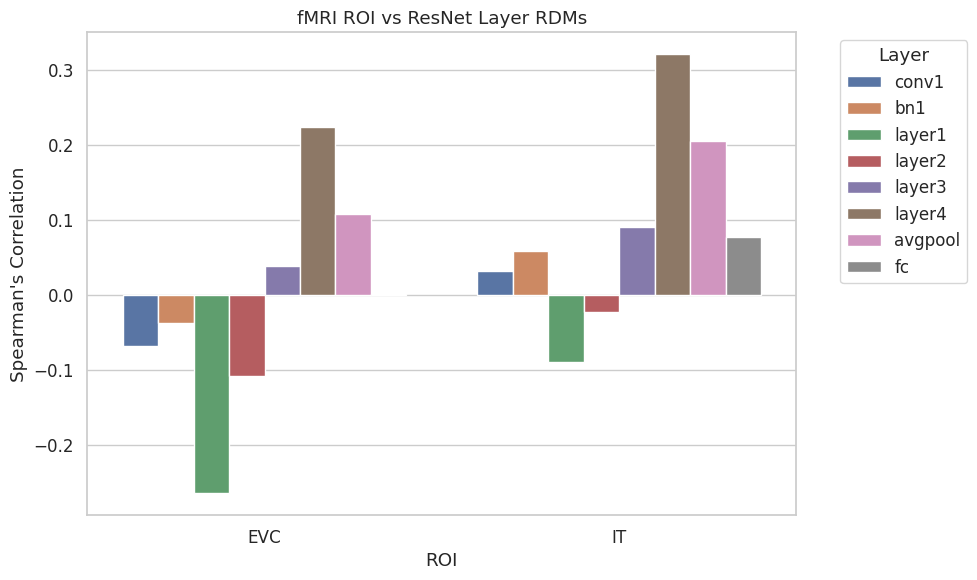

In [25]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os, glob
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 特征提取模型（ResNet18层版本）
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(ResNet18FeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.selected_layers = selected_layers

        self.model = nn.Sequential(OrderedDict([
            ('conv1', resnet.conv1),
            ('bn1', resnet.bn1),
            ('relu', resnet.relu),
            ('maxpool', resnet.maxpool),
            ('layer1', resnet.layer1),
            ('layer2', resnet.layer2),
            ('layer3', resnet.layer3),
            ('layer4', resnet.layer4),
            ('avgpool', resnet.avgpool),
        ]))
        self.fc = resnet.fc

    def forward(self, x):
        activations = []
        for name, module in self.model.named_children():
            x = module(x)
            if name in self.selected_layers:
                activations.append(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if 'fc' in self.selected_layers:
            activations.append(x)
        return activations

# 提取特征
def extract_resnet_features(model, image_list, save_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    model.eval()
    if torch.cuda.is_available():
        model.cuda()

    for img_path in tqdm(image_list):
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
        with torch.no_grad():
            feats = model(input_tensor)
        basename = os.path.splitext(os.path.basename(img_path))[0]
        for i, feat in enumerate(feats):
            np_feat = feat.cpu().numpy().ravel()
            np.save(os.path.join(save_dir, f"{basename}_layer{i+1}.npy"), np_feat)

# 计算 RDM
def compute_model_rdms(activation_dir, num_layers):
    model_RDMs = {}
    for layer in range(1, num_layers + 1):
        files = sorted(glob.glob(os.path.join(activation_dir, f'*_layer{layer}.npy')))
        data = [np.load(f) for f in files]
        data = np.array(data)
        rdm = 1 - np.corrcoef(data)
        model_RDMs[f'layer_{layer}'] = rdm
    return model_RDMs

# RSA Spearman 计算
def rsa_spearman(rdm1, rdm2):
    triu = np.triu_indices(rdm1.shape[0], k=1)
    return spearmanr(rdm1[triu], rdm2[triu])[0]

# RSA 对比
def compute_rsa_correlations(model_RDMs, MEG_RDM, fMRI_RDMs):
    results = []
    for layer in model_RDMs:
        model_rdm = model_RDMs[layer]

        # MEG over time
        for t in range(MEG_RDM.shape[0]):
            corr = rsa_spearman(model_rdm, MEG_RDM[t])
            results.append({'DataType': 'MEG', 'Layer': layer, 'Time': t, 'ROI': 'NA', 'Correlation': corr})

        # fMRI over ROIs
        for roi in ['EVC', 'IT']:
            fmri_rdm = fMRI_RDMs[roi + '_RDMs'].mean(axis=0)
            corr = rsa_spearman(model_rdm, fmri_rdm)
            results.append({'DataType': 'fMRI', 'Layer': layer, 'Time': np.nan, 'ROI': roi, 'Correlation': corr})
    return results

# 可视化结果
def plot_rsa_results(results):
    df = pd.DataFrame(results)
    sns.set(style='whitegrid', font_scale=1.1)

    # ResNet 层标签映射
    layer_name_mapping = {
        'layer_1': 'conv1',
        'layer_2': 'bn1',
        'layer_3': 'layer1',
        'layer_4': 'layer2',
        'layer_5': 'layer3',
        'layer_6': 'layer4',
        'layer_7': 'avgpool',
        'layer_8': 'fc'
    }

    # MEG Time Course
    df_meg = df[df['DataType'] == 'MEG']
    df_meg.loc[:, 'Layer'] = df_meg['Layer'].map(layer_name_mapping)
    g = sns.FacetGrid(df_meg, col='Layer', col_wrap=4, height=3.2, sharey=True)
    g.map(sns.lineplot, 'Time', 'Correlation')
    g.set_titles("{col_name}")
    g.set_axis_labels("Time", "Spearman's Correlation")
    g.fig.suptitle('MEG vs ResNet Layer RDMs Over Time', y=1.03)
    plt.tight_layout()
    plt.show()

    # fMRI Bars
    df_fmri = df[df['DataType'] == 'fMRI']
    df_fmri.loc[:, 'Layer'] = df_fmri['Layer'].map(layer_name_mapping)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_fmri, x='ROI', y='Correlation', hue='Layer')
    plt.title('fMRI ROI vs ResNet Layer RDMs')
    plt.xlabel('ROI')
    plt.ylabel("Spearman's Correlation")
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ==== 主程序区域 ====
# 路径设定
image_dir = 'data/92_Image_Set/92images'
save_dir = 'resnet_activations'
os.makedirs(save_dir, exist_ok=True)

# 加载图像列表
image_list = sorted(glob.glob(image_dir + '/*.jpg'))

# 初始化模型（18层）
selected_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
model = ResNet18FeatureExtractor(selected_layers)

# 提取特征
extract_resnet_features(model, image_list, save_dir)

# 构建模型 RDMs
model_RDMs = compute_model_rdms(save_dir, len(selected_layers))

# 加载脑数据（需预先准备）
# MEG_RDM_sub_averaged: shape = (1301, N, N)
# fMRI_RDMs = {'EVC_RDMs': [...], 'IT_RDMs': [...]}

# 比较 RDMs
results = compute_rsa_correlations(model_RDMs, MEG_RDM_sub_averaged, fMRI_RDMs)

# 可视化
plot_rsa_results(results)


# **Creating other model - AlexNet & ResNet18(v1.0)**

------------- Saving Fused Features ----------------


100%|██████████| 92/92 [00:16<00:00,  5.50it/s]


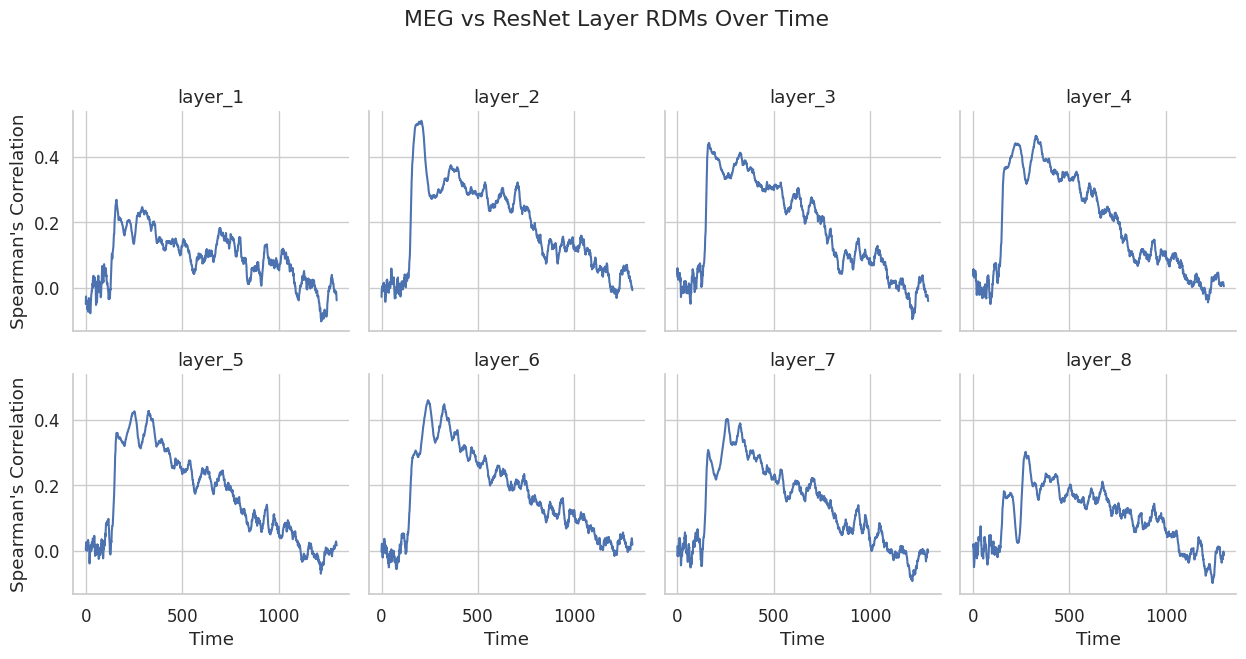

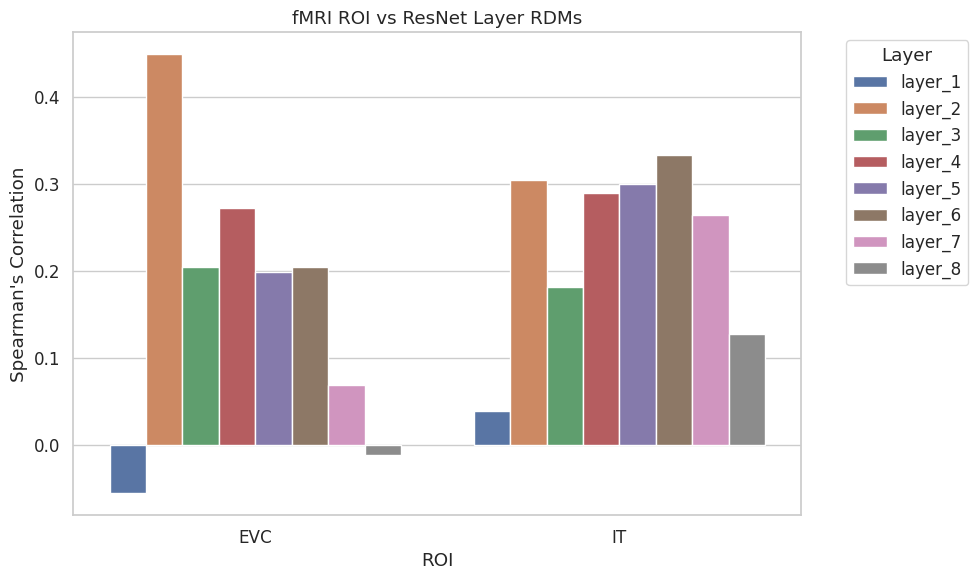

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os, glob, urllib.request
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ========= ResNet 提取器 =========
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.selected_layers = selected_layers

        self.model = nn.Sequential(OrderedDict([
            ('conv1', resnet.conv1),
            ('bn1', resnet.bn1),
            ('relu', resnet.relu),
            ('maxpool', resnet.maxpool),
            ('layer1', resnet.layer1),
            ('layer2', resnet.layer2),
            ('layer3', resnet.layer3),
            ('layer4', resnet.layer4),
            ('avgpool', resnet.avgpool),
        ]))
        self.fc = resnet.fc

    def forward(self, x):
        activations = []
        for name, module in self.model.named_children():
            x = module(x)
            if name in self.selected_layers:
                activations.append(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if 'fc' in self.selected_layers:
            activations.append(x)
        return activations

# ========= 自定义 AlexNet =========
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
        )
        self.fc7 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
        )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)
        out5_flat = out5.view(out5.size(0), 256 * 6 * 6)
        out6 = self.fc6(out5_flat)
        out7 = self.fc7(out6)
        out8 = self.fc8(out7)
        return [out1, out2, out3, out4, out5, out6, out7, out8]

# ========= 融合模型 =========
class FusionNet(nn.Module):
    def __init__(self, resnet_layers, pretrained_alexnet_ckpt):
        super(FusionNet, self).__init__()
        self.resnet = ResNetFeatureExtractor(resnet_layers)
        self.alexnet = AlexNet()

        checkpoint = torch.load(pretrained_alexnet_ckpt, map_location='cpu', weights_only=False)
        alexnet_keys = [
            "conv1.0.weight", "conv1.0.bias",
            "conv2.0.weight", "conv2.0.bias",
            "conv3.0.weight", "conv3.0.bias",
            "conv4.0.weight", "conv4.0.bias",
            "conv5.0.weight", "conv5.0.bias",
            "fc6.1.weight", "fc6.1.bias",
            "fc7.1.weight", "fc7.1.bias",
            "fc8.1.weight", "fc8.1.bias",
        ]
        state_dict = {}
        for i, (k, v) in enumerate(checkpoint.items()):
            state_dict[alexnet_keys[i]] = v
        self.alexnet.load_state_dict(state_dict)

    def forward(self, x, fusion_mode='concat'):
        resnet_feats = self.resnet(x)
        alexnet_feats = self.alexnet(x)
        fused_feats = []
        for r_feat, a_feat in zip(resnet_feats, alexnet_feats):
            r_flat = torch.flatten(r_feat, 1)
            a_flat = torch.flatten(a_feat, 1)
            if fusion_mode == 'concat':
                fused = torch.cat((r_flat, a_flat), dim=1)
            elif fusion_mode == 'mean':
                min_dim = min(r_flat.shape[1], a_flat.shape[1])
                fused = 0.5 * (r_flat[:, :min_dim] + a_flat[:, :min_dim])
            else:
                raise ValueError("Unsupported fusion mode.")
            fused_feats.append(fused)
        return fused_feats

# ========= 提取并保存特征 =========
def extract_resnet_features(model, image_list, save_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    model.eval()
    if torch.cuda.is_available():
        model.cuda()

    for img_path in tqdm(image_list):
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
        with torch.no_grad():
            feats = model(input_tensor)
        basename = os.path.splitext(os.path.basename(img_path))[0]
        for i, feat in enumerate(feats):
            np_feat = feat.cpu().numpy().ravel()
            np.save(os.path.join(save_dir, f"{basename}_layer{i+1}.npy"), np_feat)

# ========= 构建模型 RDM =========
def compute_model_rdms(activation_dir, num_layers):
    model_RDMs = {}
    for layer in range(1, num_layers + 1):
        files = sorted(glob.glob(os.path.join(activation_dir, f'*_layer{layer}.npy')))
        data = [np.load(f) for f in files]
        data = np.array(data)
        rdm = 1 - np.corrcoef(data)
        model_RDMs[f'layer_{layer}'] = rdm
    return model_RDMs

# ========= RSA Spearman =========
def rsa_spearman(rdm1, rdm2):
    triu = np.triu_indices(rdm1.shape[0], k=1)
    return spearmanr(rdm1[triu], rdm2[triu])[0]

# ========= RSA 对比计算 =========
def compute_rsa_correlations(model_RDMs, MEG_RDM, fMRI_RDMs):
    results = []
    for layer in model_RDMs:
        model_rdm = model_RDMs[layer]
        for t in range(MEG_RDM.shape[0]):
            corr = rsa_spearman(model_rdm, MEG_RDM[t])
            results.append({'DataType': 'MEG', 'Layer': layer, 'Time': t, 'ROI': 'NA', 'Correlation': corr})
        for roi in ['EVC', 'IT']:
            fmri_rdm = fMRI_RDMs[roi + '_RDMs'].mean(axis=0)
            corr = rsa_spearman(model_rdm, fmri_rdm)
            results.append({'DataType': 'fMRI', 'Layer': layer, 'Time': np.nan, 'ROI': roi, 'Correlation': corr})
    return results

# ========= 绘图函数（原样保留） =========
def plot_rsa_results(results):
    df = pd.DataFrame(results)
    sns.set(style='whitegrid', font_scale=1.1)

    # MEG Time Course
    df_meg = df[df['DataType'] == 'MEG']
    g = sns.FacetGrid(df_meg, col='Layer', col_wrap=4, height=3.2, sharey=True)
    g.map(sns.lineplot, 'Time', 'Correlation')
    g.set_titles("{col_name}")
    g.set_axis_labels("Time", "Spearman's Correlation")
    g.fig.suptitle('MEG vs ResNet Layer RDMs Over Time', y=1.03)
    plt.tight_layout()
    plt.show()

    # fMRI Bars
    df_fmri = df[df['DataType'] == 'fMRI']
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_fmri, x='ROI', y='Correlation', hue='Layer')
    plt.title('fMRI ROI vs ResNet Layer RDMs')
    plt.xlabel('ROI')
    plt.ylabel("Spearman's Correlation")
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ========= 主程序 =========
image_dir = 'data/92_Image_Set/92images'
save_dir = 'fused_activations'
checkpoint_path = 'alexnet.pth'

# 下载预训练 alexnet 权重
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, checkpoint_path)

# 加载图像
image_list = sorted(glob.glob(image_dir + '/*.jpg'))

# 初始化融合模型
selected_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
fusion_model = FusionNet(selected_layers, checkpoint_path)

# 提取融合特征并保存
os.makedirs(save_dir, exist_ok=True)
print("------------- Saving Fused Features ----------------")
extract_resnet_features(fusion_model, image_list, save_dir)

# 构建模型 RDM
model_RDMs = compute_model_rdms(save_dir, num_layers=len(selected_layers))

# === 加载 MEG / fMRI 数据（你应提前准备） ===
# MEG_RDM_sub_averaged: shape = (1301, N, N)
# fMRI_RDMs = {
#     'EVC_RDMs': array shape = (subjects, N, N),
#     'IT_RDMs': array shape = (subjects, N, N)
# }

# === 计算 RSA ===
results = compute_rsa_correlations(model_RDMs, MEG_RDM_sub_averaged, fMRI_RDMs)

# === 可视化结果 ===
plot_rsa_results(results)


# **Creating other model - AlexNet & ResNet18(v2.0)**

------------- Saving Fused Features ----------------


100%|██████████| 92/92 [00:17<00:00,  5.24it/s]


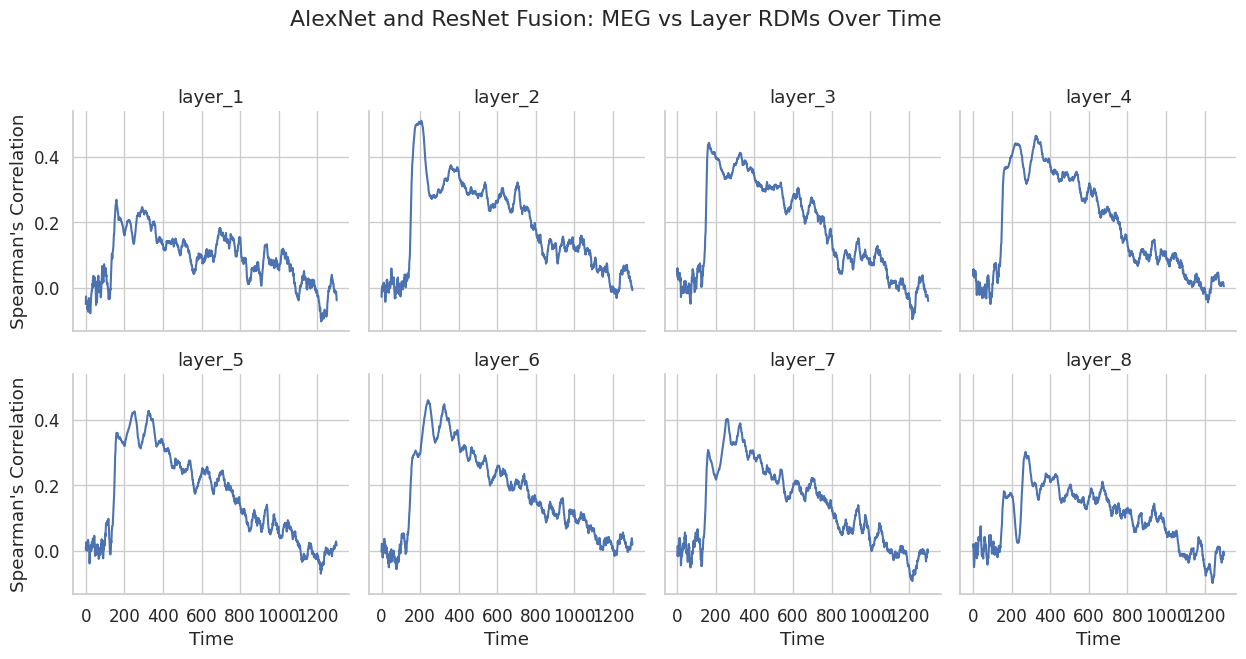

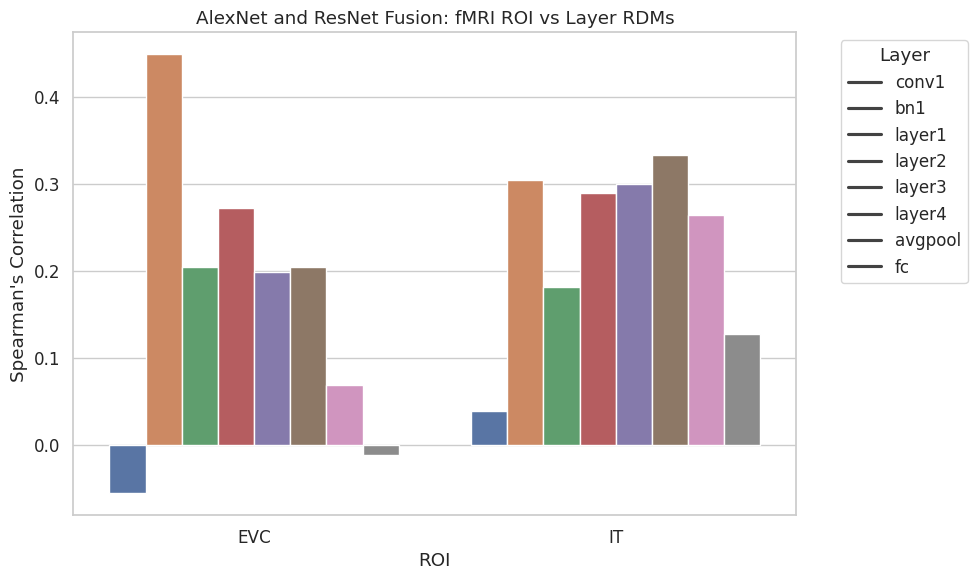

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os, glob, urllib.request
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ========= ResNet 提取器 =========
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.selected_layers = selected_layers

        self.model = nn.Sequential(OrderedDict([
            ('conv1', resnet.conv1),
            ('bn1', resnet.bn1),
            ('relu', resnet.relu),
            ('maxpool', resnet.maxpool),
            ('layer1', resnet.layer1),
            ('layer2', resnet.layer2),
            ('layer3', resnet.layer3),
            ('layer4', resnet.layer4),
            ('avgpool', resnet.avgpool),
        ]))
        self.fc = resnet.fc

    def forward(self, x):
        activations = []
        for name, module in self.model.named_children():
            x = module(x)
            if name in self.selected_layers:
                activations.append(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if 'fc' in self.selected_layers:
            activations.append(x)
        return activations

# ========= 自定义 AlexNet =========
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
        )
        self.fc7 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
        )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)
        out5_flat = out5.view(out5.size(0), 256 * 6 * 6)
        out6 = self.fc6(out5_flat)
        out7 = self.fc7(out6)
        out8 = self.fc8(out7)
        return [out1, out2, out3, out4, out5, out6, out7, out8]

# ========= 融合模型 =========
class FusionNet(nn.Module):
    def __init__(self, resnet_layers, pretrained_alexnet_ckpt):
        super(FusionNet, self).__init__()
        self.resnet = ResNetFeatureExtractor(resnet_layers)
        self.alexnet = AlexNet()

        checkpoint = torch.load(pretrained_alexnet_ckpt, map_location='cpu', weights_only=False)
        alexnet_keys = [
            "conv1.0.weight", "conv1.0.bias",
            "conv2.0.weight", "conv2.0.bias",
            "conv3.0.weight", "conv3.0.bias",
            "conv4.0.weight", "conv4.0.bias",
            "conv5.0.weight", "conv5.0.bias",
            "fc6.1.weight", "fc6.1.bias",
            "fc7.1.weight", "fc7.1.bias",
            "fc8.1.weight", "fc8.1.bias",
        ]
        state_dict = {}
        for i, (k, v) in enumerate(checkpoint.items()):
            state_dict[alexnet_keys[i]] = v
        self.alexnet.load_state_dict(state_dict)

    def forward(self, x, fusion_mode='concat'):
        resnet_feats = self.resnet(x)
        alexnet_feats = self.alexnet(x)
        fused_feats = []
        for r_feat, a_feat in zip(resnet_feats, alexnet_feats):
            r_flat = torch.flatten(r_feat, 1)
            a_flat = torch.flatten(a_feat, 1)
            if fusion_mode == 'concat':
                fused = torch.cat((r_flat, a_flat), dim=1)
            elif fusion_mode == 'mean':
                min_dim = min(r_flat.shape[1], a_flat.shape[1])
                fused = 0.5 * (r_flat[:, :min_dim] + a_flat[:, :min_dim])
            else:
                raise ValueError("Unsupported fusion mode.")
            fused_feats.append(fused)
        return fused_feats

# ========= 提取并保存特征 =========
def extract_resnet_features(model, image_list, save_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    model.eval()
    if torch.cuda.is_available():
        model.cuda()

    for img_path in tqdm(image_list):
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
        with torch.no_grad():
            feats = model(input_tensor)
        basename = os.path.splitext(os.path.basename(img_path))[0]
        for i, feat in enumerate(feats):
            np_feat = feat.cpu().numpy().ravel()
            np.save(os.path.join(save_dir, f"{basename}_layer{i+1}.npy"), np_feat)

# ========= 构建模型 RDM =========
def compute_model_rdms(activation_dir, num_layers):
    model_RDMs = {}
    for layer in range(1, num_layers + 1):
        files = sorted(glob.glob(os.path.join(activation_dir, f'*_layer{layer}.npy')))
        data = [np.load(f) for f in files]
        data = np.array(data)
        rdm = 1 - np.corrcoef(data)
        model_RDMs[f'layer_{layer}'] = rdm
    return model_RDMs

# ========= RSA Spearman =========
def rsa_spearman(rdm1, rdm2):
    triu = np.triu_indices(rdm1.shape[0], k=1)
    return spearmanr(rdm1[triu], rdm2[triu])[0]

# ========= RSA 对比计算 =========
def compute_rsa_correlations(model_RDMs, MEG_RDM, fMRI_RDMs):
    results = []
    for layer in model_RDMs:
        model_rdm = model_RDMs[layer]
        for t in range(MEG_RDM.shape[0]):
            corr = rsa_spearman(model_rdm, MEG_RDM[t])
            results.append({'DataType': 'MEG', 'Layer': layer, 'Time': t, 'ROI': 'NA', 'Correlation': corr})
        for roi in ['EVC', 'IT']:
            fmri_rdm = fMRI_RDMs[roi + '_RDMs'].mean(axis=0)
            corr = rsa_spearman(model_rdm, fmri_rdm)
            results.append({'DataType': 'fMRI', 'Layer': layer, 'Time': np.nan, 'ROI': roi, 'Correlation': corr})
    return results

# ========= 绘图函数（修改标签为ResNet层名称） =========
def plot_rsa_results(results):
    df = pd.DataFrame(results)
    sns.set(style='whitegrid', font_scale=1.1)

    # ResNet层名称
    resnet_layers = [
        'conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'
    ]

    # MEG Time Course
    df_meg = df[df['DataType'] == 'MEG']
    g = sns.FacetGrid(df_meg, col='Layer', col_wrap=4, height=3.2, sharey=True)
    g.map(sns.lineplot, 'Time', 'Correlation')
    g.set_titles("{col_name}")
    g.set_axis_labels("Time", "Spearman's Correlation")
    g.fig.suptitle('AlexNet and ResNet Fusion: MEG vs Layer RDMs Over Time', y=1.03)
    g.set(xticks=np.arange(0, df_meg['Time'].max(), 200))
    plt.tight_layout()
    plt.show()

    # fMRI Bars
    df_fmri = df[df['DataType'] == 'fMRI']
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_fmri, x='ROI', y='Correlation', hue='Layer')
    plt.title('AlexNet and ResNet Fusion: fMRI ROI vs Layer RDMs')
    plt.xlabel('ROI')
    plt.ylabel("Spearman's Correlation")
    plt.legend(title='Layer', labels=resnet_layers, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ========= 主程序 =========
image_dir = 'data/92_Image_Set/92images'
save_dir = 'fused_activations'
checkpoint_path = 'alexnet.pth'

# 下载预训练 alexnet 权重
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, checkpoint_path)

# 加载图像
image_list = sorted(glob.glob(image_dir + '/*.jpg'))

# 初始化融合模型
selected_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
fusion_model = FusionNet(selected_layers, checkpoint_path)

# 提取融合特征并保存
os.makedirs(save_dir, exist_ok=True)
print("------------- Saving Fused Features ----------------")
extract_resnet_features(fusion_model, image_list, save_dir)

# 构建模型 RDM
model_RDMs = compute_model_rdms(save_dir, num_layers=len(selected_layers))

# === 加载 MEG / fMRI 数据（你应提前准备） ===
# MEG_RDM_sub_averaged: shape = (1301, N, N)
# fMRI_RDMs = {
#     'EVC_RDMs': array shape = (subjects, N, N),
#     'IT_RDMs': array shape = (subjects, N, N)
# }

# === 计算 RSA ===
results = compute_rsa_correlations(model_RDMs, MEG_RDM_sub_averaged, fMRI_RDMs)

# === 可视化结果 ===
plot_rsa_results(results)


# **Creating other model - Test**

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as trn
import numpy as np
import os, glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# === 定义三个模型的特征提取器 ===

# ResNet18 特征提取器
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(ResNet18FeatureExtractor, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.selected_layers = selected_layers

    def forward(self, x):
        activations = []

        # 遍历模型的各个子层
        for name, layer in self.model.named_children():
            x = layer(x)

            # 如果是你选中的层，则保存其输出
            if name in self.selected_layers:
                activations.append(x)

        # 确保展平操作在进入fc之前进行
        if 'fc' in self.selected_layers:
            x = torch.flatten(x, 1)  # 对输出进行展平，展平后的形状为 [batch_size, features]
            activations.append(x)

        return activations

# VGG16 特征提取器
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(VGG16FeatureExtractor, self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.selected_layers = selected_layers

    def forward(self, x):
        activations = []
        for i, layer in enumerate(self.model.features):
            x = layer(x)
            if f"features.{i}" in self.selected_layers:
                activations.append(x)
        x = torch.flatten(x, 1)  # 展平操作
        for i, layer in enumerate(self.model.classifier):
            x = layer(x)
            if f"classifier.{i}" in self.selected_layers:
                activations.append(x)
        return activations

# AlexNet 特征提取器
class AlexNetFeatureExtractor(nn.Module):
    def __init__(self, selected_layers):
        super(AlexNetFeatureExtractor, self).__init__()
        self.model = models.alexnet(pretrained=True)
        self.selected_layers = selected_layers

    def forward(self, x):
        activations = []
        for i, layer in enumerate(self.model.features):
            x = layer(x)
            if f"features.{i}" in self.selected_layers:
                activations.append(x)
        x = torch.flatten(x, 1)  # 展平操作
        for i, layer in enumerate(self.model.classifier):
            x = layer(x)
            if f"classifier.{i}" in self.selected_layers:
                activations.append(x)
        return activations


# === 提取特征并保存 ===
def get_activations_and_save(model, image_list, activations_dir, model_name):
    preprocess = trn.Compose([
        trn.Resize((224, 224)),
        trn.ToTensor(),
        trn.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
    ])

    for image_file in tqdm(image_list):
        image_name = os.path.splitext(os.path.basename(image_file))[0]
        img = Image.open(image_file).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
            model.cuda()
        with torch.no_grad():
            feats = model(input_tensor)
        for i, feat in enumerate(feats):
            feat_np = feat.cpu().numpy().ravel()
            save_path = os.path.join(activations_dir, f"{model_name}_{image_name}_layer{i+1}.npy")
            np.save(save_path, feat_np)


# === 融合模型 ===
class FusionNet(nn.Module):
    def __init__(self, resnet_model, vgg_model, alexnet_model):
        super(FusionNet, self).__init__()
        self.resnet = resnet_model
        self.vgg = vgg_model
        self.alexnet = alexnet_model

    def forward(self, x):
        resnet_feats = self.resnet(x)
        vgg_feats = self.vgg(x)
        alexnet_feats = self.alexnet(x)
        fused_feats = torch.cat(resnet_feats + vgg_feats + alexnet_feats, dim=1)
        return fused_feats


# === 计算 RDM ===
def compute_rdms(activations_dir, num_layers):
    model_RDMs = {}
    for layer in range(1, num_layers + 1):
        print(f'Processing layer {layer}')
        files = sorted(glob.glob(os.path.join(activations_dir, f'*_layer{layer}.npy')))
        features = [np.load(f) for f in files]
        features = np.array(features)
        rdm = 1 - np.corrcoef(features)
        model_RDMs[f"layer_{layer}"] = rdm
    return model_RDMs


# === RSA Spearman 计算 ===
def rsa_spearman(rdm1, rdm2):
    triu = np.triu_indices(rdm1.shape[0], k=1)
    return spearmanr(rdm1[triu], rdm2[triu])[0]


# === RSA 对比计算 ===
def compute_rsa_correlations(model_RDMs, MEG_RDM, fMRI_RDMs):
    results = []
    for layer in model_RDMs:
        model_rdm = model_RDMs[layer]
        for t in range(MEG_RDM.shape[0]):
            corr = rsa_spearman(model_rdm, MEG_RDM[t])
            results.append({'DataType': 'MEG', 'Layer': layer, 'Time': t, 'ROI': 'NA', 'Correlation': corr})

        for roi in ['EVC', 'IT']:
            fmri_rdm = fMRI_RDMs[roi + '_RDMs'].mean(axis=0)
            corr = rsa_spearman(model_rdm, fmri_rdm)
            results.append({'DataType': 'fMRI', 'Layer': layer, 'Time': np.nan, 'ROI': roi, 'Correlation': corr})
    return results


# === 可视化结果 ===
def plot_rsa_results(results):
    df = pd.DataFrame(results)
    sns.set(style='whitegrid', font_scale=1.1)

    # 层名称映射
    layer_name_mapping = {
        'layer_1': 'conv1',
        'layer_2': 'conv2',
        'layer_3': 'conv3',
        'layer_4': 'conv4',
        'layer_5': 'conv5',
        'layer_6': 'fc6',
        'layer_7': 'fc7',
        'layer_8': 'fc8'
    }

    # MEG 时间序列
    df_meg = df[df['DataType'] == 'MEG']
    df_meg.loc[:, 'Layer'] = df_meg['Layer'].map(layer_name_mapping)
    g = sns.FacetGrid(df_meg, col='Layer', col_wrap=4, height=3.2, sharey=True)
    g.map(sns.lineplot, 'Time', 'Correlation')
    g.set_titles("{col_name}")
    g.set_axis_labels("Time", "Spearman's Correlation")
    g.fig.suptitle('MEG vs Fusion Model Layer RDMs Over Time', y=1.03)
    plt.tight_layout()
    plt.show()

    # fMRI 条形图
    df_fmri = df[df['DataType'] == 'fMRI']
    df_fmri.loc[:, 'Layer'] = df_fmri['Layer'].map(layer_name_mapping)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_fmri, x='ROI', y='Correlation', hue='Layer')
    plt.title('fMRI ROI vs Fusion Model Layer RDMs')
    plt.xlabel('ROI')
    plt.ylabel("Spearman's Correlation")
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# === 主程序 ===

# 设置路径
image_dir = 'data/92_Image_Set/92images'
save_dir = 'fusion_activations'
os.makedirs(save_dir, exist_ok=True)

# 加载图像
image_list = sorted(glob.glob(image_dir + '/*.jpg'))

# 初始化模型
resnet_model = ResNet18FeatureExtractor(selected_layers)
vgg_model = VGG16FeatureExtractor(layer_names)
alexnet_model = AlexNetFeatureExtractor(layer_names)

# 融合模型
fusion_model = FusionNet(resnet_model, vgg_model, alexnet_model)
fusion_model.eval()

# 提取特征
get_activations_and_save(resnet_model, image_list, save_dir, "resnet")
get_activations_and_save(vgg_model, image_list, save_dir, "vgg")
get_activations_and_save(alexnet_model, image_list, save_dir, "alexnet")

# 计算 RDM
model_RDMs = compute_rdms(save_dir, num_layers=len(selected_layers))

# 加载 MEG 和 fMRI 数据
# MEG_RDM_sub_averaged: shape = (1301, N, N)
# fMRI_RDMs = {'EVC_RDMs': [...], 'IT_RDMs': [...]}

# 计算 RDMs 的 RSA 对比
results = compute_rsa_correlations(model_RDMs, MEG_RDM_sub_averaged, fMRI_RDMs)

# 绘制结果
plot_rsa_results(results)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x1 and 512x1000)